In [1]:
import wandb
import pandas as pd
from datasets import load_dataset
from utils.datasets import get_dataset
from tqdm import tqdm
import concurrent.futures
from utils.utils import (
    plot_confidence_error,
    expected_calibration_error,
    calculate_auroc,
    calculate_macro_ece,
)
from utils.utils import (
    extract_texts_and_confidences,
    extract_answer,
    compute_f1,
    compute_exact_match,
)
from tqdm import tqdm
from utils.chat import Chat
import math
tqdm.pandas()

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
runs = pd.read_csv("csv/inference.csv")
runs = runs[runs["prompt"] == "multistep"]
runs = runs[runs["dataset"] == "MuSiQue"]
runs = runs[runs["model"].apply(lambda x: x not in ["gpt-4o", "gpt-4o-mini"])]
runs

,Name,ID,dataset,model,prompt
5,brisk-sun-792,l1vy1axf,MuSiQue,DeepSeek-V3,multistep
15,comic-dew-786,ukkob161,MuSiQue,Llama-3.3-70B,multistep


In [7]:
from utils.utils import extract_texts_and_confidences
import random
    
def extract_steps(sample):
    texts, confs = extract_texts_and_confidences(sample["response"])
    steps = list(zip(texts, confs))
    if not steps:
        return {}
    steps = sorted(steps, key=lambda x: x[1])
    steps = [steps[0], steps[-1], random.choice(steps)]
    return {
        "id": sample["id"],
        "question" : sample["question"],
        "answer" : sample["answer"],
        "steps": list([step[0] for step in steps]),
        "confs": list([step[1] for step in steps])
    }

In [8]:
def process_ds(sample, is_musique=False):
    if is_musique:
        sample["facts"] = [par["paragraph_text"] for par in sample["paragraphs"]]
    else:
        sample["facts"] = [sent for sentences in sample["context"]["sentences"] for sent in sentences]
    return sample

In [9]:
from sentence_transformers import SentenceTransformer
enc_model = SentenceTransformer("all-MiniLM-L6-v2")

def process_similarity(sample):
    sentences1 = sample["steps"]
    sentences2 = sample["facts"]

    # Compute embeddings for both lists
    embeddings1 = enc_model.encode(sentences1)
    embeddings2 = enc_model.encode(sentences2)
    
    # Compute cosine similarities
    similarities = enc_model.similarity(embeddings1, embeddings2)
    indices = similarities.argmax(dim=1)

    chosen_facts = [sentences2[indices[i]] for i in range(len(sentences1))] 

    return chosen_facts


In [10]:
k = 5
prompt = (
    "Provide your best guess for the following multi-hop question. "
    f"Provide a step-by-step explanation of your thought process (max. {k} reasoning steps). "
    "Each step should only contain a single new fact and be on a new line. "
    "When enough information is present, give your final answer on a new line with no other words or explanation. "
    "Also provide how confident you are between 0.0 and 1.0 that a given line is correct.\n\n"
    "<format>\n"
    "Step 1: {first reasoning step} Confidence: {confidence for step 1}\n"
    "Step 2: {second reasoning step} Confidence: {confidence for step 2}\n"
    "...\n"
    "Final Answer: {most likely guess, as short as possible; not a complete sentence, just the guess!} "
    "Confidence: {final confidence for your answer}\n"
    "</format>\n"
)

def process_sample(sample, i):
    question, answer = sample["question"], sample["answer"]
    chat = Chat(prompt, **llm_config)
    chat.add_message("The question is: " + question, "user")
    supporting_fact = "Supporting Fact: " + sample["chosen_fact"][i]
    chat.add_message(supporting_fact, "user")
    response = chat.response()
    texts, confidences = extract_texts_and_confidences(response)
    
    # Force answer is none was given
    if not confidences or not texts:
        return {"response": response}
        
    confidence = math.prod(confidences)
    prediction = texts[-1]

    results = {
        "response": response,
        "prediction": prediction,
        "confidence": confidence,
        "f1": compute_f1(prediction, answer),
        "em": compute_exact_match(prediction, answer),  # type: ignore
    }
    return results

In [11]:
for _, row in runs.iterrows():
    model = row["model"]
    dataset = row["dataset"]
    table_id = row["ID"]

    run = wandb.init(project="uncertainty-reimplimentation-results", job_type="choose_facts",tags=["ablation_study"])
    artifact = run.use_artifact(f"hofbauer/uncertainty-reimplimentation-results/run-{table_id}-table:v0")
    run.config.update(artifact.logged_by().config)
    table = artifact.get("table").get_dataframe()
    # extract steps
    table_steps = pd.DataFrame(list(table.apply(extract_steps, axis=1)))

    # get all facts from dataset for each question
    is_musique = dataset == "MuSiQue"
    ds = get_dataset(dataset, all_collumns=True, num_samples=table.shape[0])
    ds_facts = ds.map(lambda x: process_ds(x, is_musique=is_musique)).to_pandas()[["id", "facts"]].set_index("id")

    table_combined = table_steps.set_index("id").join(ds_facts)
    
    table_combined = table_combined.dropna()
    table_combined["chosen_fact"] = table_combined.progress_apply(process_similarity, axis=1)
    table_combined = table_combined.drop(columns=["facts"])
    
    log_table = wandb.Table(dataframe=table_combined)
    wandb.log({"table" : log_table})
    wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lukas-hofbauer (hofbauer) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb:   1 of 1 files downloaded.  
100%|████████████████████████████████████████████████████████████████████| 1000/1000 [14:21<00:00,  1.16it/s]


wandb:   1 of 1 files downloaded.  


Map:   0%|          | 0/998 [00:00<?, ? examples/s]

100%|██████████████████████████████████████████████████████████████████████| 996/996 [15:02<00:00,  1.10it/s]


In [15]:
runs = pd.read_csv("csv/ablation_input.csv")
#runs = runs[runs["prompt"] == "multistep"]
runs = runs[runs["model"] != "gpt-4o-mini"]
runs = runs[runs["dataset"] == "MuSiQue"]
runs

,Name,ID,dataset,model
0,worldly-wood-968,454ohscf,MuSiQue,DeepSeek-V3
3,dark-meadow-969,k4ie5232,MuSiQue,Llama-3.3-70B
4,worldly-paper-931,m0juwxy9,MuSiQue,gpt-4o


wandb:   1 of 1 files downloaded.  
100%|████████████████████████████████████████████████████████████████████| 1000/1000 [11:29<00:00,  1.45it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.228
auroc,0.69417
ece,0.27018
f1,0.35049
macro_ece,0.42387


wandb:   1 of 1 files downloaded.  
100%|████████████████████████████████████████████████████████████████████| 1000/1000 [10:07<00:00,  1.65it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.21021
auroc,0.682
ece,0.28532
f1,0.32952
macro_ece,0.42555


wandb:   1 of 1 files downloaded.  
100%|████████████████████████████████████████████████████████████████████| 1000/1000 [09:37<00:00,  1.73it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.21343
auroc,0.67362
ece,0.2905
f1,0.3263
macro_ece,0.43163


wandb:   1 of 1 files downloaded.  
100%|██████████████████████████████████████████████████████████████████████| 996/996 [05:21<00:00,  3.10it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.22814
auroc,0.70241
ece,0.10498
f1,0.34152
macro_ece,0.41853


wandb:   1 of 1 files downloaded.  
100%|██████████████████████████████████████████████████████████████████████| 996/996 [05:52<00:00,  2.83it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.2145
auroc,0.66938
ece,0.11049
f1,0.31821
macro_ece,0.43466


wandb:   1 of 1 files downloaded.  
100%|██████████████████████████████████████████████████████████████████████| 996/996 [05:49<00:00,  2.85it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.23618
auroc,0.68662
ece,0.0976
f1,0.33959
macro_ece,0.42383


wandb:   1 of 1 files downloaded.  
100%|████████████████████████████████████████████████████████████████████| 1000/1000 [03:36<00:00,  4.62it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.2347
auroc,0.68497
ece,0.31098
f1,0.37864
macro_ece,0.41758


wandb:   1 of 1 files downloaded.  
100%|████████████████████████████████████████████████████████████████████| 1000/1000 [03:28<00:00,  4.80it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.22445
auroc,0.71057
ece,0.28741
f1,0.35169
macro_ece,0.41145


wandb:   1 of 1 files downloaded.  
100%|████████████████████████████████████████████████████████████████████| 1000/1000 [03:48<00:00,  4.38it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.24048
auroc,0.66559
ece,0.29592
f1,0.36818
macro_ece,0.42755


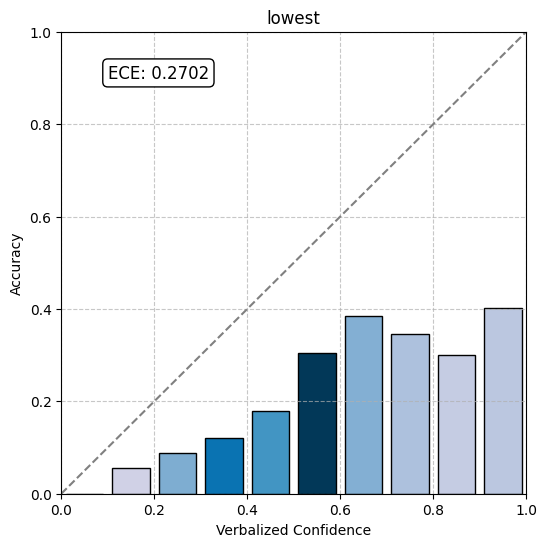

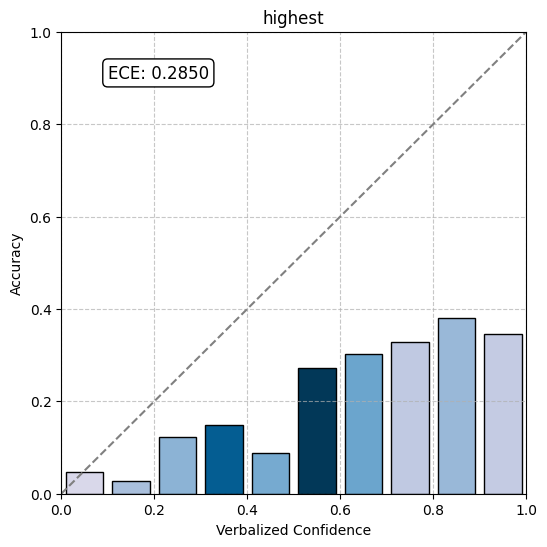

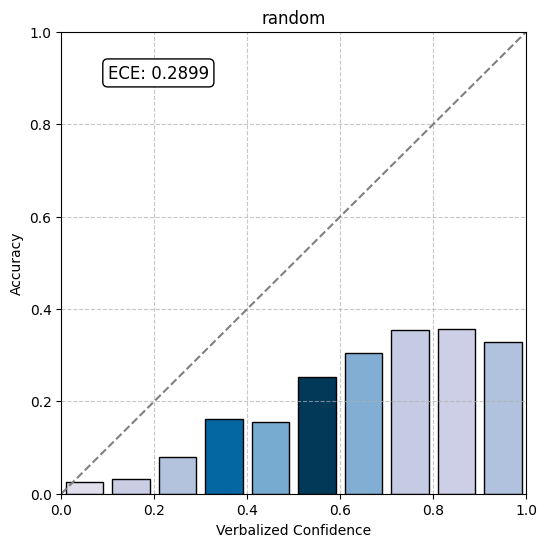

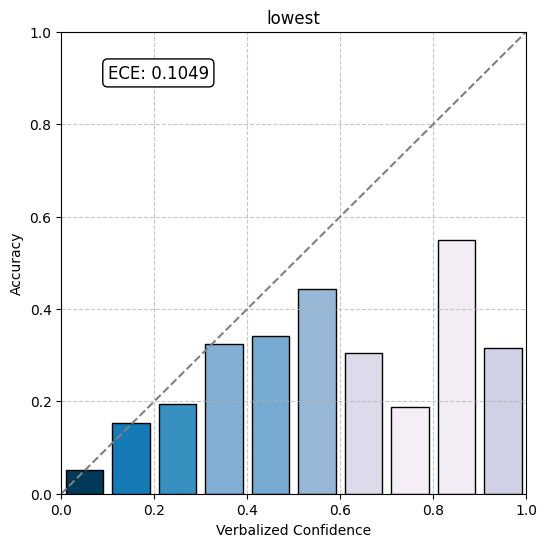

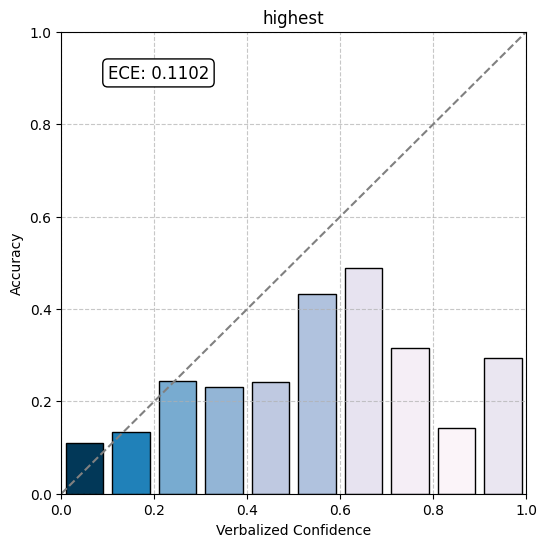

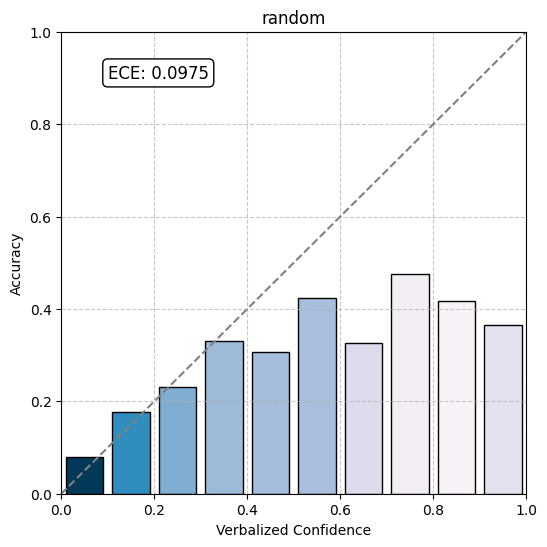

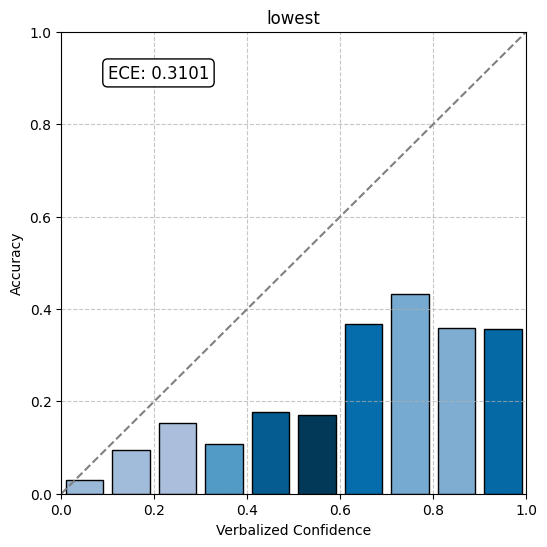

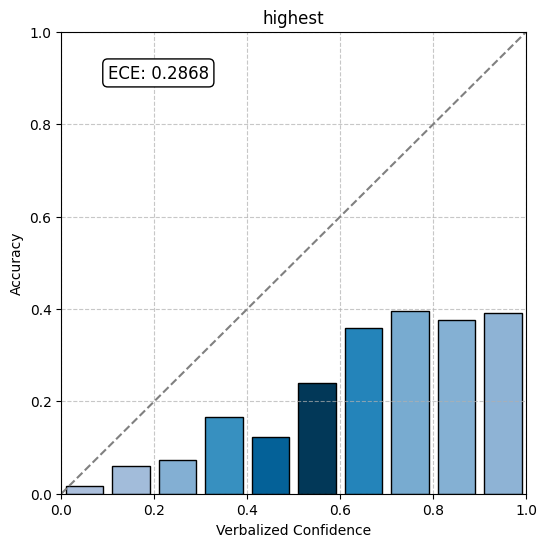

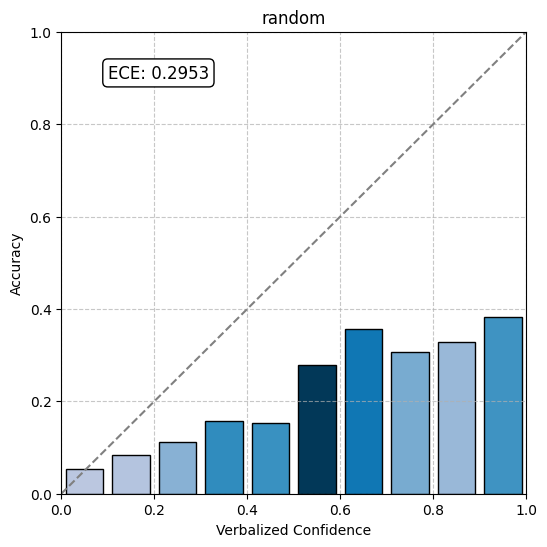

In [16]:
for _, row in runs.iterrows():
    for i, name in enumerate(["lowest", "highest", "random"]):
        table_id = row["ID"]
        llm_config = {"model": row["model"]}
        run = wandb.init(project="uncertainty-reimplimentation-results", job_type="inference",tags=["ablation_study"],config={"type" : name})
        artifact = run.use_artifact(f"hofbauer/uncertainty-reimplimentation-results/run-{table_id}-table:v0")
        df = artifact.get("table").get_dataframe()
        run.config.update(artifact.logged_by().config)

        # Process the dataset using the processor in parallel
        with concurrent.futures.ThreadPoolExecutor(
            max_workers=10
        ) as executor:
            responses = pd.DataFrame(
                tqdm(
                    executor.map(lambda x: process_sample(x,i), df.to_dict("records")),
                    total=df.shape[0],
                )
            )
    
        df = pd.concat([df, responses], axis=1)
    
        table = wandb.Table(dataframe=df)
        wandb.log({"table": table})
        wandb.finish()

        table_id = run.id
### EVAL 
        run = wandb.init(project="uncertainty-reimplimentation-results", job_type="eval",tags=["ablation_study"])
    
        artifact = run.use_artifact(f"hofbauer/uncertainty-reimplimentation-results/run-{table_id}-table:v0")
        table: pd.DataFrame = artifact.get("table").get_dataframe()
        run.config.update(artifact.logged_by().config)
    
        fig, _ = plot_confidence_error(
            table["em"],
            table["confidence"],
            title=name,
            ylabel="Accuracy",
            xlabel="Verbalized Confidence",
        )
    
        table = table.dropna()  ## remove missing rows
    
        f1_score = table["f1"].mean()
        accuracy = table["em"].mean()
        ece_score = expected_calibration_error(table["em"], table["confidence"])
        auroc_score = calculate_auroc(table["em"], table["confidence"])
        macro_ece_score = calculate_macro_ece(table)
    
        wandb.log(
            {
                "f1": f1_score,
                "acc": accuracy,
                "ece": ece_score,
                "auroc": auroc_score,
                "macro_ece": macro_ece_score,
            }
        )
    
        wandb.log({"calibration_plot": wandb.Image(fig)})
    
        run.finish()

In [ ]:
for _, row in runs.iterrows():
    for i, name in enumerate(["highest", "random"]):
        table_id = row["ID"]
        llm_config = {"model": row["model"]}
        run = wandb.init(project="uncertainty-reimplimentation-results", job_type="inference",tags=["ablation_study"],config={"type" : name})
        artifact = run.use_artifact(f"hofbauer/uncertainty-reimplimentation-results/run-{table_id}-table:v0")
        df = artifact.get("table").get_dataframe()
        run.config.update(artifact.logged_by().config)
    
        # Process the dataset using the processor in parallel
        with concurrent.futures.ThreadPoolExecutor(
            max_workers=10
        ) as executor:
            responses = pd.DataFrame(
                tqdm(
                    executor.map(lambda x: process_sample(x,i), df.to_dict("records")),
                    total=df.shape[0],
                )
            )
    
        df = pd.concat([df, responses], axis=1)
    
        table = wandb.Table(dataframe=df)
        wandb.log({"table": table})
        wandb.finish()

        table_id = run.id
### EVAL 
        run = wandb.init(project="uncertainty-reimplimentation-results", job_type="eval",tags=["ablation_study"])
    
        artifact = run.use_artifact(f"hofbauer/uncertainty-reimplimentation-results/run-{table_id}-table:v0")
        table: pd.DataFrame = artifact.get("table").get_dataframe()
        run.config.update(artifact.logged_by().config)
    
        fig, _ = plot_confidence_error(
            table["em"],
            table["confidence"],
            title=name,
            ylabel="Accuracy",
            xlabel="Verbalized Confidence",
        )
    
        table = table.dropna()  ## remove missing rows
    
        f1_score = table["f1"].mean()
        accuracy = table["em"].mean()
        ece_score = expected_calibration_error(table["em"], table["confidence"])
        auroc_score = calculate_auroc(table["em"], table["confidence"])
        macro_ece_score = calculate_macro_ece(table)
    
        wandb.log(
            {
                "f1": f1_score,
                "acc": accuracy,
                "ece": ece_score,
                "auroc": auroc_score,
                "macro_ece": macro_ece_score,
            }
        )
    
        wandb.log({"calibration_plot": wandb.Image(fig)})
    
        run.finish()

wandb:   1 of 1 files downloaded.  


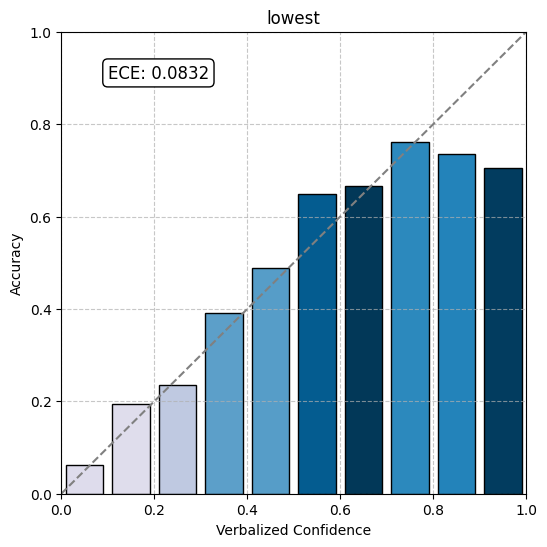

In [23]:
p

In [148]:
runs = pd.read_csv("csv/ablation_output.csv")
runs = runs[runs["prompt"] == "multistep"]
runs = runs[runs["model"] == "gpt-4o"]
runs = runs[runs["dataset"] == "HotpotQA"]
runs

'MuSiQue'

In [27]:
wandb.finish()

In [45]:
        run = wandb.init(project="uncertainty-reimplimentation-results", job_type="eval",tags=["ablation_study"],
    
        artifact = run.use_artifact(f"hofbauer/uncertainty-reimplimentation-results/run-{table_id}-table:v0")
        table: pd.DataFrame = artifact.get("table").get_dataframe()
        run.config.update(table_artifact.logged_by().config)
    
        fig, _ = plot_confidence_error(
            table["em"],
            table["confidence"],
            title=name,
            ylabel="Accuracy",
            xlabel="Verbalized Confidence",
        )
    
        table = table.dropna()  ## remove missing rows
    
        f1_score = table["f1"].mean()
        accuracy = table["em"].mean()
        ece_score = expected_calibration_error(table["em"], table["confidence"])
        auroc_score = calculate_auroc(table["em"], table["confidence"])
        macro_ece_score = calculate_macro_ece(table)
    
        wandb.log(
            {
                "f1": f1_score,
                "acc": accuracy,
                "ece": ece_score,
                "auroc": auroc_score,
                "macro_ece": macro_ece_score,
            }
        )
    
        wandb.log({"calibration_plot": wandb.Image(fig)})
    
        run.finish()

In [49]:
api = wandb.Api()
artifact = api.artifact(f"hofbauer/uncertainty-reimplimentation-results/run-{table_id}-table:v0")
table = artifact.get("table").get_dataframe()

wandb:   1 of 1 files downloaded.  


In [50]:
#run = wandb.init(project="ablation_study", job_type="create_table")
#artifact = run.use_artifact(f"hofbauer/uncertainty-reimplimentation-results/run-{table_id}-table:v0")
#df = artifact.get("table").get_dataframe()

In [51]:
#run.config.update(artifact.logged_by().config)

In [79]:
ds = get_dataset(dataset, all_collumns=True, num_samples=table.shape[0])
facts = ds.map(process_ds).to_pandas()[["id", "facts"]].set_index("id")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [125]:
combined = steps.set_index("id").join(facts)

In [119]:
combined = combined.dropna()
combined["chosen_fact"] = combined.progress_apply(process_similarity, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:23<00:00,  1.98it/s]


In [82]:
combined = combined.drop("facts", axis=1)
artifact = wandb.Artifact(f"{model}-{dataset}", type="selected_facts")
table = wandb.Table(dataframe=combined)
artifact.add(table, "table")
run.log_artifact(artifact)
wandb.finish()

In [83]:
table_id = f"run-{run.id}-table"

In [129]:
combined[combined["chosen_fact"].apply(lambda x: x[0] != x[1])]

,question,answer,steps,confs,facts,chosen_fact
id,,,,,,
5ae3cfe05542990afbd1e1e3,"Which airport is located in Maine, Sacramento ...",Knox County Regional Airport,[Airports can serve as distinguishing features...,"[0.9, 1.0, 0.9]",[Vinalhaven is a town located on the larger of...,[ It is an FAA certified commercial airport se...
5abc1abf5542993a06baf87f,Peter Hobbs founded the company that is based ...,Failsworth,[After considering known companies associated ...,"[0.5, 0.9, 0.7]","[Cains is a brewery in Liverpool, England, fou...","[ It covers Cheshire, Greater Manchester, Lanc..."
5ac250eb5542992f1f2b384f,What direction does the river that Austrolebia...,north to south,"[Specifically, Austrolebias bellotti is found ...","[0.7, 0.9, 0.85]","[The Cruces River (Spanish: ""Río Cruces"" ) is ...",[Austrolebias bellottii is a species of fish t...
5a81a60455429903bc27b990,Were both Gabriela Mistral and G. K. Chesterto...,yes,[Gabriela Mistral was a Chilean poet and diplo...,"[1.0, 1.0, 1.0]","[Mistral is a crater on Mercury., It has a di...",[ Mistral is named for the Chilean poet Gabrie...
5a70fb2d5542994082a3e482,"What city, other than San Jose del Cabo, is at...",Cabo San Lucas,[The southern tip of Baja California Peninsula...,"[0.9, 0.95, 0.95]",[Santa Anita is a village in Los Cabos Municip...,[Los Cabos (] ) is a municipality located at t...
...,...,...,...,...,...,...
5a8f75ee5542997ba9cb3276,Are both Moist and Plain White T's opera groups?,no,"[The term ""opera groups"" generally refers to m...","[0.9, 0.95, 0.95]",[Duck rice () is a Singaporean Chinese meat di...,"[ It consists of David Usher as lead vocalist,..."
5a83c6f2554299334474608e,Jeffry Fortes is a Dutch-born professional foo...,23 July 1902,[Research indicates that Jeffry Fortes plays f...,"[0.7, 0.9, 0.9]",[Queen of the South Football Club are a Scotti...,[Jeffry Fortes (born 22 March 1989 in Rotterda...
5ae5397655429960a22e0275,Jaina Proudmoore is currently voiced by the vo...,Kid Trunks and Kid Dende,"[Laura Bailey voiced the character ""Bra"" in Dr...","[0.6, 0.9, 0.9]",[Dragon Ball Z: The Legacy of Goku is a series...,[Laura Dawn Bailey is an American voice actres...


wandb:   1 of 1 files downloaded.  
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 997/997 [08:59<00:00,  1.85it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.51964
auroc,0.61804
ece,0.11201
f1,0.6577
macro_ece,0.45744


wandb:   1 of 1 files downloaded.  
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 997/997 [08:50<00:00,  1.88it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.50452
auroc,0.64098
ece,0.08789
f1,0.65089
macro_ece,0.45233


wandb:   1 of 1 files downloaded.  
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 997/997 [09:37<00:00,  1.73it/s]


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.49146
auroc,0.65161
ece,0.09351
f1,0.63494
macro_ece,0.44427


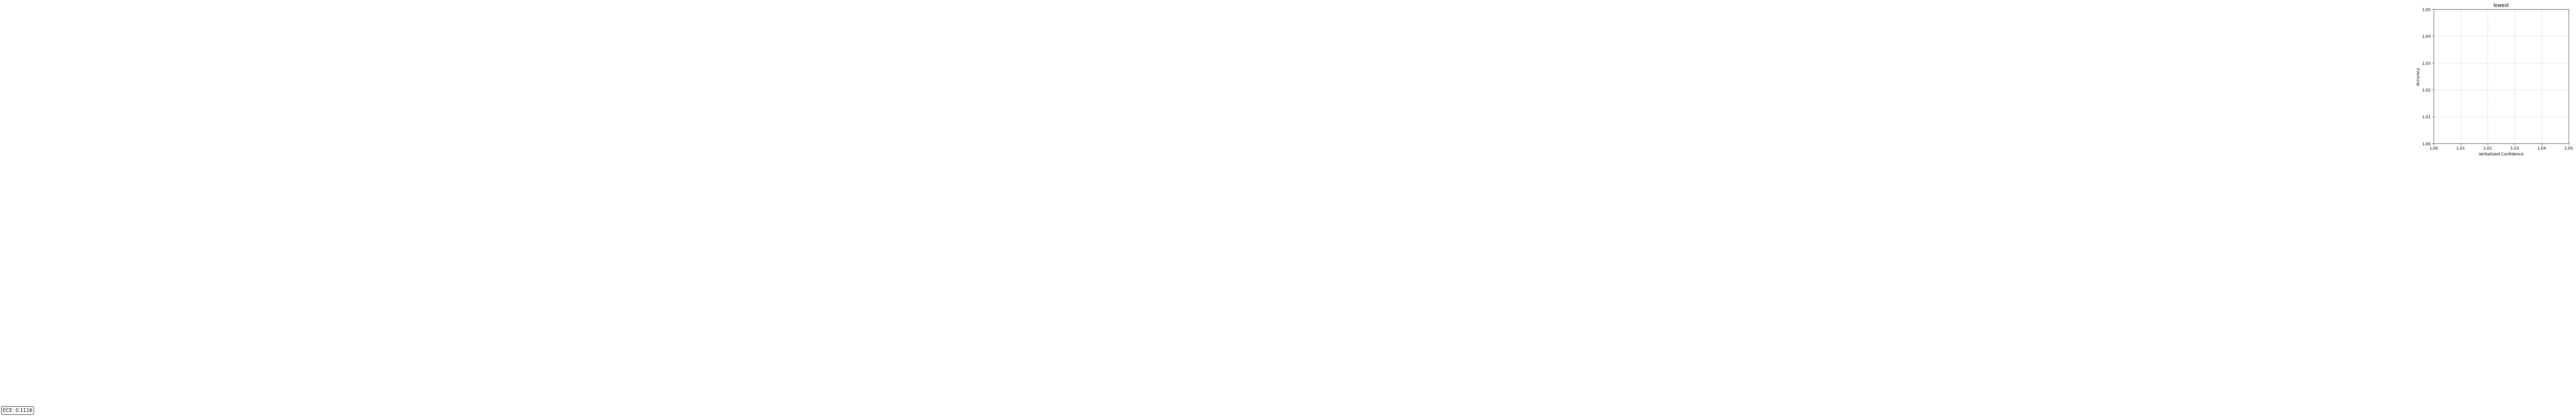

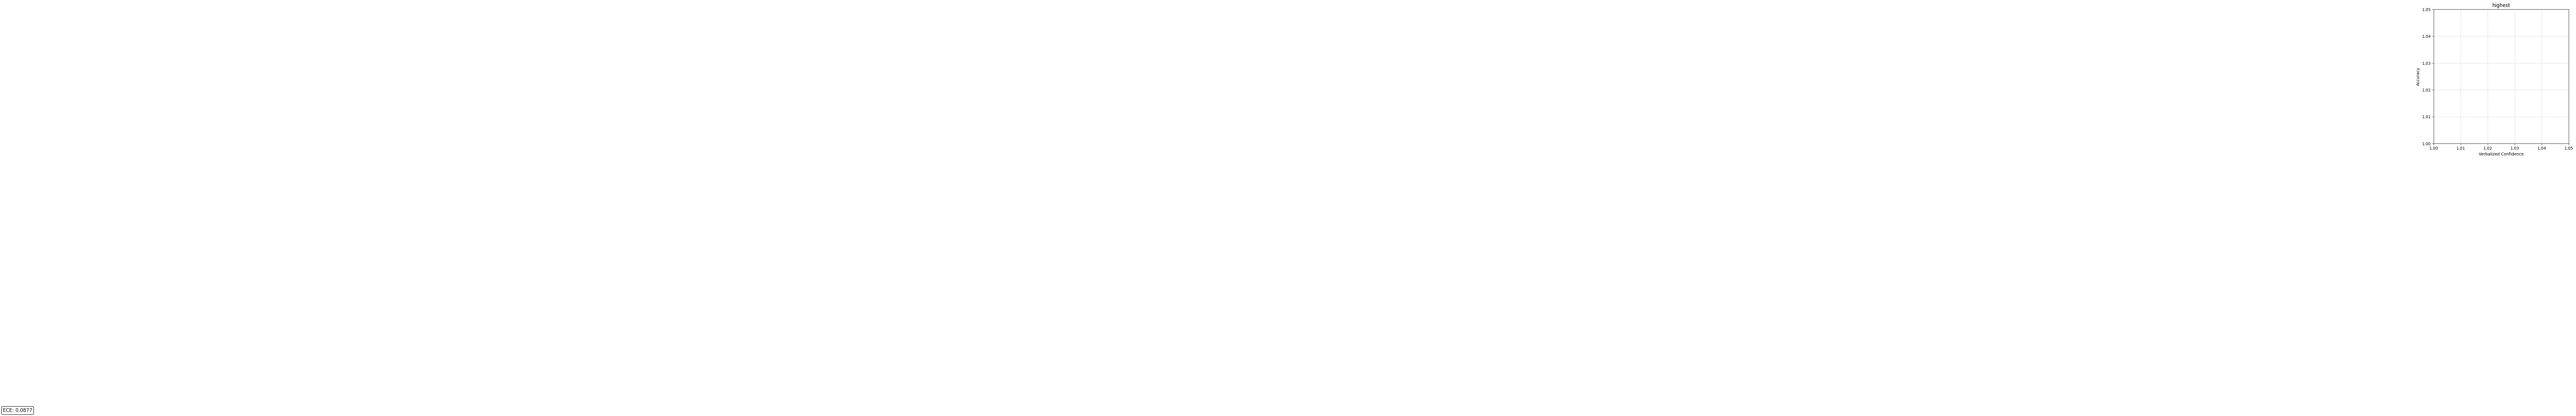

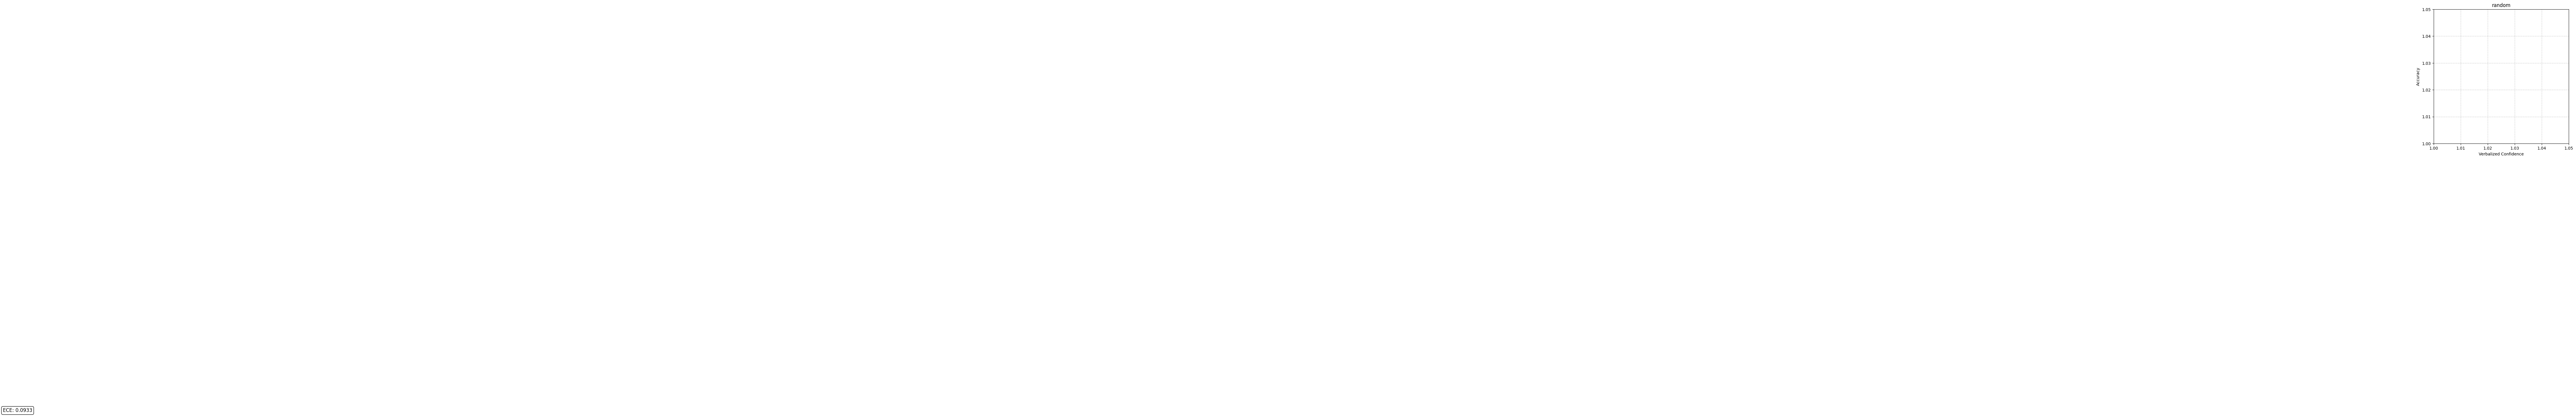

In [84]:
import concurrent.futures
from utils.utils import (
    plot_confidence_error,
    expected_calibration_error,
    calculate_auroc,
    calculate_macro_ece,
)
from utils.utils import (
    extract_texts_and_confidences,
    extract_answer,
    compute_f1,
    compute_exact_match,
)
from tqdm import tqdm
from utils.chat import Chat
import math

for i, name in enumerate(["lowest", "highest", "random"]):
    run = wandb.init(
        project="ablation_study", 
        job_type="inference",
        config={"type" : name}
    )
    artifact = run.use_artifact(f"hofbauer/ablation_study/{model}-{dataset}:latest")
    df = artifact.get("table").get_dataframe()
    run.config.update(artifact.logged_by().config)

    # Process the dataset using the processor in parallel
    with concurrent.futures.ThreadPoolExecutor(
        max_workers=10
    ) as executor:
        responses = pd.DataFrame(
            tqdm(
                executor.map(lambda x: process_sample(x,i), df.to_dict("records")),
                total=df.shape[0],
            )
        )

    # Combine dataset with responses
    df = pd.concat([df, responses], axis=1)

    # Get BERT score NOTE: Ignore this doesn't work
    # _, _, df["bert_score"] = score(df["answer"], df["prediction"], lang="en")

    # Log Table
    table = wandb.Table(dataframe=df)
    wandb.log({"table": table})
    wandb.finish()

    results_table = f"run-{run.id}-table"

###### EVAL ####
for i, name in enumerate(["lowest", "highest", "random"]):
    run = wandb.init(
        project="ablation_study",
        job_type="eval",
    )

    table_artifact = run.use_artifact(
        f"ablation_study/{model}-{dataset}-{name}:latest"
    )
    
    table: pd.DataFrame = table_artifact.get("table").get_dataframe()
    
    run.config.update(table_artifact.logged_by().config)

    fig, _ = plot_confidence_error(
        table["em"],
        table["confidence"],
        title=name,
        ylabel="Accuracy",
        xlabel="Verbalized Confidence",
    )

    table = table.dropna()  ## remove missing rows

    f1_score = table["f1"].mean()
    accuracy = table["em"].mean()
    ece_score = expected_calibration_error(table["em"], table["confidence"])
    auroc_score = calculate_auroc(table["em"], table["confidence"])
    macro_ece_score = calculate_macro_ece(table)

    wandb.log(
        {
            "f1": f1_score,
            "acc": accuracy,
            "ece": ece_score,
            "auroc": auroc_score,
            "macro_ece": macro_ece_score,
        }
    )

    wandb.log({"calibration_plot": wandb.Image(fig)})

    run.finish()

wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.51964
auroc,0.61804
ece,0.11201
f1,0.6577
macro_ece,0.45744


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.50452
auroc,0.64098
ece,0.08789
f1,0.65089
macro_ece,0.45233


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.49146
auroc,0.65161
ece,0.09351
f1,0.63494
macro_ece,0.44427


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.52761
auroc,0.62749
ece,0.15298
f1,0.66819
macro_ece,0.43707


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.51329
auroc,0.64014
ece,0.14943
f1,0.65073
macro_ece,0.43051


wandb:   1 of 1 files downloaded.  


acc,▁
auroc,▁
ece,▁
f1,▁
macro_ece,▁
acc,0.51125
auroc,0.64315
ece,0.14526
f1,0.6495
macro_ece,0.43175


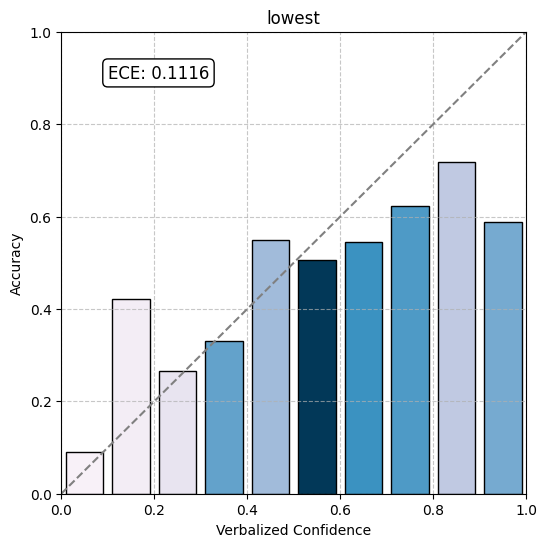

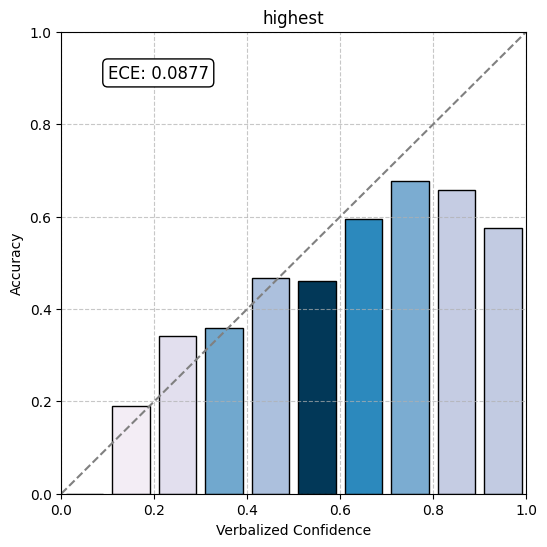

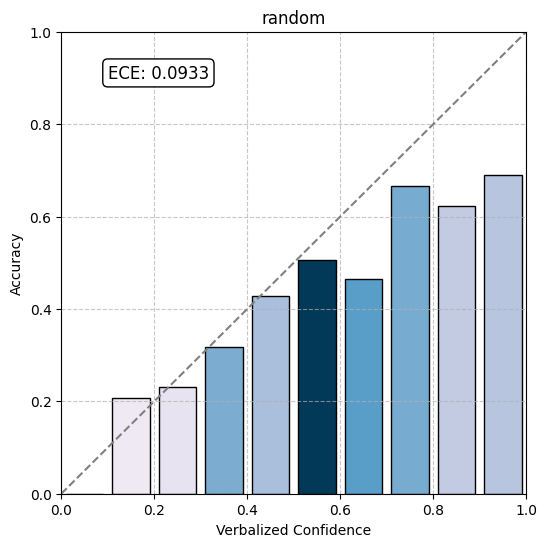

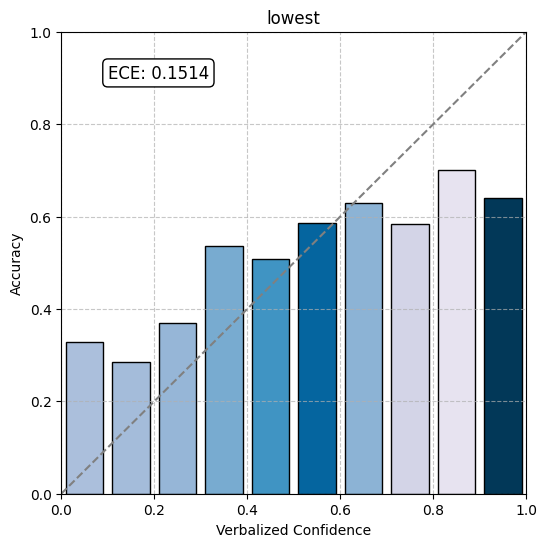

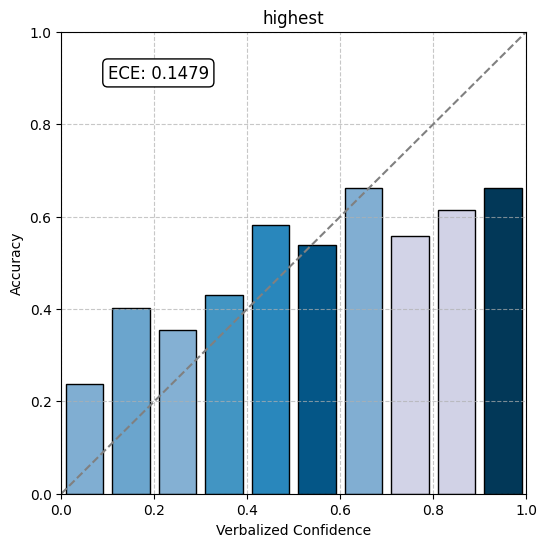

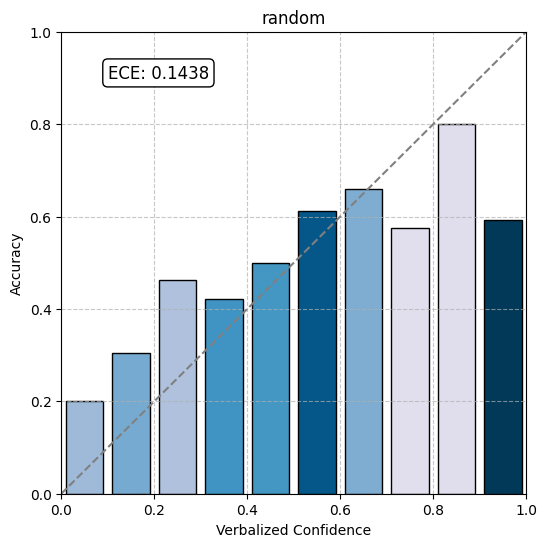

In [103]:
for model in ["DeepSeek-V3", "Llama-3.3-70B"]:
    for i, name in enumerate(["lowest", "highest", "random"]):
        run = wandb.init(
            project="ablation_study",
            job_type="eval",
        )
    
        table_artifact = run.use_artifact(
            f"ablation_study/{model}-{dataset}-{name}:latest"
        )
        
        table: pd.DataFrame = table_artifact.get("table").get_dataframe()
        
        run.config.update(table_artifact.logged_by().config)
    
        fig, _ = plot_confidence_error(
            table["em"],
            table["confidence"],
            title=name,
            ylabel="Accuracy",
            xlabel="Verbalized Confidence",
        )
    
        table = table.dropna()  ## remove missing rows
    
        f1_score = table["f1"].mean()
        accuracy = table["em"].mean()
        ece_score = expected_calibration_error(table["em"], table["confidence"])
        auroc_score = calculate_auroc(table["em"], table["confidence"])
        macro_ece_score = calculate_macro_ece(table)
    
        wandb.log(
            {
                "f1": f1_score,
                "acc": accuracy,
                "ece": ece_score,
                "auroc": auroc_score,
                "macro_ece": macro_ece_score,
            }
        )
        
        wandb.log({"calibration_plot": wandb.Image(fig)})
    
        run.finish()